<a href="https://colab.research.google.com/github/UCREL/Session1_Visualisation_and_Summarisation/blob/main/Extra-NoteBooks/ArabicNews_wordcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Arabic News

Arabic news crawled from BBC, CNN, JSC, RT, and EuroNews
https://www.kaggle.com/datasets/mksaad/arabic-news/data

In [1]:
!pip install mglearn
!pip install gdown
!pip install wordcloud
!pip install plotly
!pip install spacy
!pip install spacy-langdetect
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.1/998.1 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993414 sha256=d51942481ac5ac2716fac4f41c7f9571ecbd2f2341afd48028382e67f8e3a564
  Stored in directory: /root/.cache/pip/wheels/97/f1/e4/8b73f7a0421b132755956892d29b1e764d3e0857a6e92e32fe
Successfully built langdetect


In [2]:
import gdown
url = 'https://drive.google.com/uc?id=1REOz6rfcjPuIhIimsrpBwhifvmI9gCTx'
output = 'Arabic_news.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1REOz6rfcjPuIhIimsrpBwhifvmI9gCTx
From (redirected): https://drive.google.com/uc?id=1REOz6rfcjPuIhIimsrpBwhifvmI9gCTx&confirm=t&uuid=a4a21f4f-8d84-443f-aa9f-ff2103493e2d
To: /content/Arabic_news.zip
100%|██████████| 603M/603M [00:17<00:00, 35.0MB/s]


'Arabic_news.zip'

In [3]:
import zipfile
import os

if zipfile.is_zipfile(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Files extracted:")
    print(os.listdir('/content/'))
else:
    print("Downloaded file is not a zip file.")

Files extracted:
['.config', 'Arabic_news.zip', 'Arabic_news.csv', 'sample_data']


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Arabic_news.csv')

# Display the first few rows of the DataFrame
df.head()

,title,description,date_download,date_publish,source_domain,url,text,image_url,authors,title_page
0,قطر تشتري حصة بشركة شل,أكدت متحدثة باسم شركة شل أن قطر اشترت حصة بالش...,2019-04-20,2012-05-11,aljazeera.net,https://www.aljazeera.net/news/ebusiness/2012/...,الصندوق السيادي القطري يستهدف الاستثمار في كبر...,https://www.aljazeera.net/file/GetImageCustom/...,[],قطر تشتري حصة بشركة شل
1,مجلس الأمن يبحث طلب فلسطين,يبحث الخميس مجلس الأمن الدولي مشروع تقرير بشأن...,2019-04-20,2011-11-03,aljazeera.net,https://www.aljazeera.net/news/arabic/2011/11/...,عباس قدم طلب عضوية بلاده في الأمم المتحدة في 2...,https://www.aljazeera.net/file/GetImageCustom/...,[],مجلس الأمن يبحث طلب فلسطين
2,بلاتر: العقوبة ضد السودان عادلة,قال رئيس الاتحاد الدولي لكرة القدم (الفيفا) جو...,2019-04-20,2012-10-16,aljazeera.net,https://www.aljazeera.net/news/sport/2012/10/1...,جوزيف بلاتر خلال لقائه الصحفيين في جنيف (الجزي...,https://www.aljazeera.net/Views/Shared/shared/...,[],بلاتر: العقوبة ضد السودان عادلة
3,العراق يلغي صفقة سلاح مع روسيا,قال متحدث باسم رئيس الوزراء العراقي نوري المال...,2019-04-20,2012-11-10,aljazeera.net,https://www.aljazeera.net/news/arabic/2012/11/...,وزير الدفاع العراقي بالوكالة سعدون الدليمي قال...,https://www.aljazeera.net/Views/Shared/shared/...,[],العراق يلغي صفقة سلاح مع روسيا
4,جدل بمصر حول قرارات مرسي,انعكست حالة الاستقطاب التي عانت منها مصر في ال...,2019-04-20,2012-11-22,aljazeera.net,https://www.aljazeera.net/news/reportsandinter...,مؤيدون لقرارات الرئيس مرسي يتظاهرون أمام دار ا...,https://www.aljazeera.net/Views/Shared/shared/...,[],جدل بمصر حول قرارات مرسي


In [7]:
df.shape

(600313, 10)

In [8]:

df.describe()


,title,description,date_download,date_publish,source_domain,url,text,image_url,authors,title_page
count,600313,596553,600313,597703,600313,600313,600313,600313,600313,600313
unique,383536,381260,5,6137,5,384811,384004,276414,5496,383767
top,قتلى وجرحى بهجمات في العراق,صفحة التغطية المباشرة اليومية من بي بي سي عربي,2019-04-19,2019-01-17,arabic.rt.com,https://www.aljazeera.net/news/sport/2004/1/17...,ok\nباستخدامك موقعنا، انت توافق على خصوصية الا...,https://cdni.rt.com/media/pics/static.ar/origi...,[],قتلى وجرحى بهجمات في العراق
freq,42,176,239667,673,334268,4,555,114089,424059,42


In [9]:
df.isnull().sum() #no missing values

title               0
description      3760
date_download       0
date_publish     2610
source_domain       0
url                 0
text                0
image_url           0
authors             0
title_page          0
dtype: int64

In [15]:
df3 = df.loc[:,['description', 'source_domain','url']]

In [16]:
df3

,description,source_domain,url
0,أكدت متحدثة باسم شركة شل أن قطر اشترت حصة بالش...,aljazeera.net,https://www.aljazeera.net/news/ebusiness/2012/...
1,يبحث الخميس مجلس الأمن الدولي مشروع تقرير بشأن...,aljazeera.net,https://www.aljazeera.net/news/arabic/2011/11/...
2,قال رئيس الاتحاد الدولي لكرة القدم (الفيفا) جو...,aljazeera.net,https://www.aljazeera.net/news/sport/2012/10/1...
3,قال متحدث باسم رئيس الوزراء العراقي نوري المال...,aljazeera.net,https://www.aljazeera.net/news/arabic/2012/11/...
4,انعكست حالة الاستقطاب التي عانت منها مصر في ال...,aljazeera.net,https://www.aljazeera.net/news/reportsandinter...
...,...,...,...
600308,الحكم على رجل بالسجن لمدة 30 شهرا بعد أن اعترف...,bbc.com,http://www.bbc.com/arabic/worldnews/2010/08/10...
600309,أكد مصدر حكومي امريكي أن قوات تابعة للبحرية ال...,bbc.com,http://www.bbc.com/arabic/middleeast/2013/10/1...
600310,مؤسسة خيرية تدعو لزيادة تمويل العلاج النفسي لق...,bbc.com,http://www.bbc.com/arabic/scienceandtech/2015/...
600311,أفراد من الحرس الجمهوري اليمني يتظاهرون في شور...,bbc.com,http://www.bbc.com/arabic/middleeast/2012/08/1...


In [17]:
df3 = df3.rename(columns = {'description' : 'text'})

<Axes: xlabel='source_domain'>

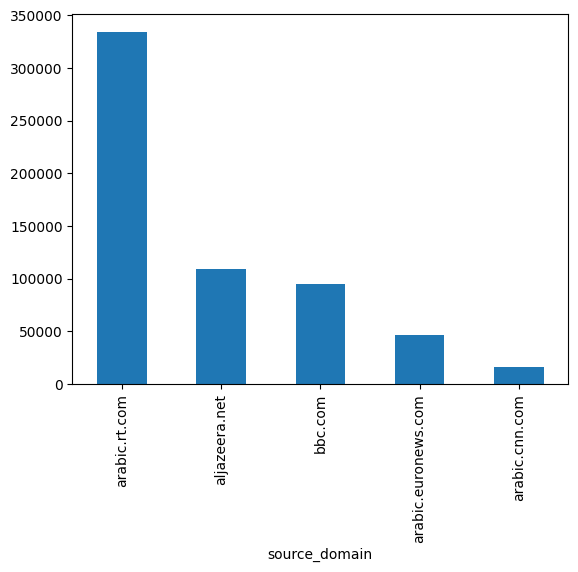

In [18]:
df3['source_domain'].value_counts().nlargest(20).plot(kind = 'bar')

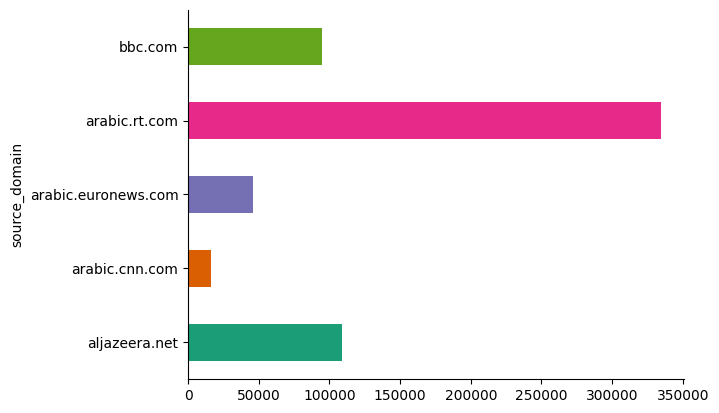

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
df3.groupby('source_domain').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
import plotly.express as px

# Use Plotly for visualisation
fig = px.bar(df3.groupby('source_domain').size().sort_values(ascending=False).reset_index(),
             x='source_domain', y=0,
             labels={'0': 'Count'},
             color='source_domain',  # Color bars based on source domain
             color_discrete_sequence=px.colors.qualitative.Pastel)  # Use a color palette

fig.update_layout(
    title='Distribution of News Sources',
    xaxis_title='Source Domain',
    yaxis_title='Count',
    showlegend=False
)

fig.show()


Data prep

### 1.2 Preprocess the text data

We will use spaCy to preprocess the text data, including tokenization and stop words removal.

In [23]:
# Display the distribution of news sources
source_counts = df['source_domain'].value_counts()
print(source_counts)
# Determine the minimum count of articles across all sources
min_count = source_counts.min()
print(f"\nMinimum count of articles across all sources: {min_count}")

# Create a balanced subset
balanced_df = df.groupby('source_domain').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Display the distribution of news sources in the balanced subset
balanced_source_counts = balanced_df['source_domain'].value_counts()
print("\nDistribution of news sources in the balanced subset:")
print(balanced_source_counts)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv('BalancedArabicNewsDataset.csv', index=False)

print("\nBalanced dataset saved to 'BalancedArabicNewsDataset.csv'")

source_domain
arabic.rt.com          334268
aljazeera.net          109141
bbc.com                 94734
arabic.euronews.com     46079
arabic.cnn.com          16091
Name: count, dtype: int64

Minimum count of articles across all sources: 16091

Distribution of news sources in the balanced subset:
source_domain
aljazeera.net          16091
arabic.cnn.com         16091
arabic.euronews.com    16091
arabic.rt.com          16091
bbc.com                16091
Name: count, dtype: int64

Balanced dataset saved to 'BalancedArabicNewsDataset.csv'


In [25]:
balanced_df

,title,description,date_download,date_publish,source_domain,url,text,image_url,authors,title_page
0,هل بحثت فتح عن بديل لعباس؟,في الوقت الذي استبعدت فيه قيادات من حركة فتح م...,2019-04-20,2009-11-10,aljazeera.net,https://www.aljazeera.net/news/reportsandinter...,محمود عباس أعلن عزمه التنحي قبل الانتخابات الف...,https://www.aljazeera.net/file/GetImageCustom/...,[],هل بحثت فتح عن بديل لعباس؟
1,الجلوس طويلا يزيد خطر الجلطات,كشفت دراسات جديدة أن الجلوس بلا نشاط لفترات طو...,2019-04-19,2016-08-17,aljazeera.net,https://www.aljazeera.net/news/healthmedicine/...,كشفت دراسات جديدة أن الجلوس بلا نشاط لفترات طو...,https://www.aljazeera.net/file/GetImageCustom/...,[],الجلوس طويلا يزيد خطر الجلطات
2,بايدن: ترامب يهدد الأمن القومي,اعتبر جو بايدن نائب الرئيس الأميركي أن المرشح ...,2019-04-19,2016-08-15,aljazeera.net,https://www.aljazeera.net/news/international/2...,انتقد جو بايدن نائب الرئيس الأميركي المرشح الج...,https://www.aljazeera.net/file/GetImageCustom/...,[],بايدن: ترامب يهدد الأمن القومي
3,الغرب يشدد عقوباته على دمشق,شدد الاتحاد الأوروبي اليوم عقوباته على سوريا ع...,2019-04-20,2011-12-01,aljazeera.net,https://www.aljazeera.net/news/arabic/2011/12/...,وزراء خارجية الاتحاد الأوروبي أضافوا 11 شركة و...,https://www.aljazeera.net/file/GetImageCustom/...,[],الغرب يشدد عقوباته على دمشق
4,"التنسيق ""أم بي3"" انتهى رسميا",أعلن معهد فرانهوفر للدوائر المتكاملة الألماني ...,2019-04-19,2017-05-15,aljazeera.net,https://www.aljazeera.net/windows/scienceandte...,أعلن معهد فرانهوفر للدوائر المتكاملة الألماني،...,https://www.aljazeera.net/Views/Shared/shared/...,[],"التنسيق ""أم بي3"" انتهى رسميا"
...,...,...,...,...,...,...,...,...,...,...
80450,"الجيش المصري: اعتقلنا 6 ""إرهابيين"" في سيناء ون...",مصادر عسكرية مصرية تعلن اعتقال ستة أشخاص وصفته...,2019-04-10,2012-08-11,bbc.com,http://www.bbc.com/arabic/middleeast/2012/08/1...,مصدر الصورة AFP Image caption الجيش يواصل عملي...,https://ichef.bbci.co.uk/news/ws/1024/branded_...,[],"الجيش المصري: اعتقلنا 6 ""إرهابيين"" في سيناء ون..."
80451,صحف عربية تبرز تقرير لجنة تحقيق عراقية عن سقوط...,صحف عربية تهتم اليوم نتائج تقرير لجنة تحقيق عر...,2019-04-10,2015-08-17,bbc.com,http://www.bbc.com/arabic/inthepress/2015/08/1...,مصدر الصورة AP Image caption من بين من اتهمتهم...,https://ichef.bbci.co.uk/news/ws/1024/branded_...,"['قسم المتابعة الإعلامية', 'بي بي سي']",صحف عربية تبرز تقرير لجنة تحقيق عراقية عن سقوط...
80452,وزير خارجية بريطانيا المستقيل بوريس جونسون صاح...,مسيرة وزير خارجية بريطانيا المستقيل بوريس جونس...,2019-04-09,2018-07-09,bbc.com,http://www.bbc.com/arabic/world-44767025,مصدر الصورة PA Image caption اثارت بعض تصريحات...,https://ichef.bbci.co.uk/news/1024/branded_ara...,[],وزير خارجية بريطانيا المستقيل بوريس جونسون صاح...
80453,أوكرانيا: حشود من المتحجين وسط العاصمة كييف,شرطة مكافحة الشغب تستعد تنتشر قرب مقر البلدية ...,2019-04-10,2013-12-09,bbc.com,http://www.bbc.com/arabic/worldnews/2013/12/13...,Image caption رجال دين طلبوا من الشرطة عدم است...,https://ichef.bbci.co.uk/news/ws/1024/branded_...,[],أوكرانيا: حشود من المتحجين وسط العاصمة كييف - ...


In [26]:
import spacy
from spacy.lang.ar import Arabic

# Load spaCy Arabic model
nlp = Arabic()

def preprocess_text(text):
    # Tokenize and remove stop words
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

balanced_df['clean_text'] = balanced_df['text'].apply(preprocess_text)

print("\nFirst few rows of the cleaned dataset:")
balanced_df[['text', 'clean_text']].head()



First few rows of the cleaned dataset:


,text,clean_text
0,محمود عباس أعلن عزمه التنحي قبل الانتخابات الف...,محمود عباس أعلن عزمه التنحي الانتخابات الفلسطي...
1,كشفت دراسات جديدة أن الجلوس بلا نشاط لفترات طو...,كشفت دراسات جديدة الجلوس نشاط لفترات طويلة -أي...
2,انتقد جو بايدن نائب الرئيس الأميركي المرشح الج...,انتقد جو بايدن نائب الرئيس الأميركي المرشح الج...
3,وزراء خارجية الاتحاد الأوروبي أضافوا 11 شركة و...,وزراء خارجية الاتحاد الأوروبي أضافوا 11 شركة و...
4,أعلن معهد فرانهوفر للدوائر المتكاملة الألماني،...,أعلن معهد فرانهوفر للدوائر المتكاملة الألماني ...


## Step 2: Data Visualization

### 2.1 Word Frequency Visualization

https://www.wordclouds.co.uk/


1. **Color Themes:**
   - `colormap='viridis'` sets a color theme for the word cloud. You can choose from various colormaps provided by Matplotlib (e.g., 'viridis', 'plasma', 'inferno', 'magma').

2. **Custom Shapes:**
   - `mask=mask` uses a custom mask image to shape the word cloud. You need to provide the path to an image file (e.g., a PNG file with a transparent background).

3. **Advanced Styling:**
   - `contour_width` and `contour_color` add contour lines to the word cloud.
   - `random_state=42` ensures reproducibility by setting a random state.
   - `max_words=200` limits the number of words displayed in the word cloud.
   - `stopwords=stopwords` removes common stop words from the word cloud.



Get font:

In [28]:
import gdown
url = 'https://drive.google.com/uc?id=1HwUK9hixOUcF_8mrpP2nD4zbyMA0utz2'
output = 'Arabic_font.ttf'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HwUK9hixOUcF_8mrpP2nD4zbyMA0utz2
To: /content/Arabic_font.ttf
100%|██████████| 225k/225k [00:00<00:00, 85.2MB/s]


'Arabic_font.ttf'

Get Image:

In [30]:
url = 'https://drive.google.com/uc?id=1WoIBqqLufm9Ou3toI5uKVIcRuC-_Qswh'
output = 'Mic.png'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WoIBqqLufm9Ou3toI5uKVIcRuC-_Qswh
To: /content/Mic.png
100%|██████████| 84.2k/84.2k [00:00<00:00, 49.6MB/s]


'Mic.png'

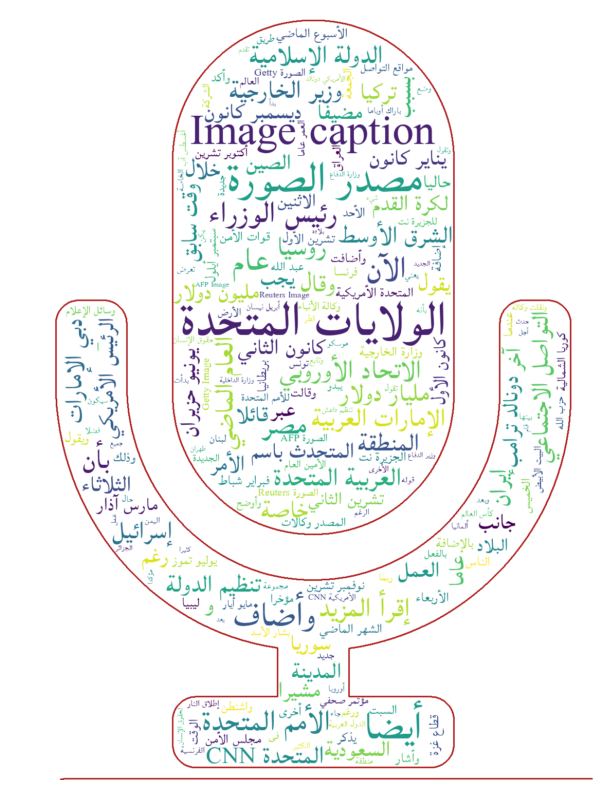

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_word_cloud(texts, mask_path, font_path):
    # Combine all texts into one string
    all_words = ' '.join(texts)

    # Load a mask image for custom shape
    mask = np.array(Image.open(mask_path))  # mask image path

    # Define stop words
    stopwords = set(STOPWORDS)

    # Create a WordCloud object with additional customization
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        max_words=200,
        stopwords=stopwords,
        mask=mask,  # Use mask for custom shape
        contour_width=3,
        contour_color='firebrick',
        colormap='viridis',  # Color theme
        width=800,
        height=400,
        random_state=42
    ).generate(all_words)

    # Display the word cloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


visualize_word_cloud(balanced_df['clean_text'], 'Mic.png', 'Arabic_font.ttf')


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_csv('BalancedArabicNewsDataset.csv', on_bad_lines='skip')

# Check for null values
print(df.isnull().sum())

# Fill or drop null values
df['description'] = df['description'].fillna('')
df['date_publish'] = df['date_publish'].fillna('Unknown')

# Use 'text' column for content and 'date_publish' or another column for labels
df['text'] = df['text'] + ' ' + df['description']  # Combining text and description if needed
df = df[['date_publish', 'text']]
df.columns = ['year', 'abstract']

# Ensure no null abstracts
df = df[pd.notnull(df['abstract'])]

# Create categories (labels) from the year column
df['category_id'] = df['year'].factorize()[0]
category_id_df = df[['year', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'year']].values)
df.head()

# Define models to use
modelsArray = ["SVM", "NB", "LR"]
for model_type in modelsArray:
    # Prepare the training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(df['abstract'], df['year'], random_state=1, test_size=0.30)

    # Vectorization
    count_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
    count_vect.fit(X_train)
    X_train_tfidf = count_vect.transform(X_train)
    X_test_tfidf = count_vect.transform(X_test)

    # Algorithms setup
    if model_type == "SVM":
        clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    if model_type == "NB":
        clf = MultinomialNB()
    if model_type == "LR":
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=4000)

    # Train the model
    train_model = clf.fit(X_train_tfidf, y_train)
    # Predicting years for testing data
    test_accuracy = train_model.predict(X_test_tfidf)
    # Print training and testing accuracy
    print("Training/Testing Accuracy", '\t', model_type, '\t', train_model.score(X_train_tfidf, y_train), '\t', train_model.score(X_test_tfidf, y_test))

    # Plot confusion matrices
    conf_mat = confusion_matrix(y_test, test_accuracy)
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="RdBu_r",
                xticklabels=category_id_df.year.values, yticklabels=category_id_df.year.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    # Save plot
    pltFileName = f'combined_{model_type}.pdf'
    plt.savefig(pltFileName)


title               0
description      1059
date_download       0
date_publish      123
source_domain       0
url                 0
text                0
image_url           0
authors             0
title_page          0
dtype: int64


now use what you learnet to visualise and explore more